# 1 Read predictions CNN
        

In [1]:
import os
import pandas as pd
import numpy as np
import re
import pickle
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer, scale
from IPython.display import display, Markdown
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import GridSearchCV
from auxiliary_functions import *
warnings.filterwarnings('ignore')

plots_dir = "plots"
PATH = "resultsFirstRound/"

##############################################################
# Obtaining best CNN execution (in validation set)
##############################################################

summary_files = [each for each in os.listdir(PATH) if each.endswith('_summary_acc.csv')]

df = pd.concat((pd.read_csv(os.path.join(PATH, f)).assign(file = f).assign(model = re.search('[0-9]_+(.+?)_summary_acc.csv', f).group(1).split("_")[0]).
                assign(set = re.search('[0-9]_+(.+?)_summary_acc.csv', f).group(1).split("_")[1]) for f in summary_files))
df_val = df[df["set"] == "valid"]

# Determining file of the best CNN execution
best_exec_acc_val = df_val[df_val["accuracy"] == max(df_val["accuracy"])]
file_best_exec = best_exec_acc_val["file"][0]

file_best_exec_id = re.search('(.+?)_[a-z]+_summary_acc.csv', file_best_exec).group(1)

##############################################################
# Reading indices of the best CNN execution
##############################################################
# Reading indices of the best CNN execution
indices_file = file_best_exec.replace("valid_summary_acc.csv", "indices.pickle")
with open(os.path.join(PATH,indices_file), 'rb') as f:
    indices = pickle.load(f)
in_train, in_valid, in_test = indices


##############################################################
# Reading predictions of the best CNN execution
##############################################################
# Reading images
img_file='images.npz'
file_dir = "data/"
images = np.load('%s/%s' % (file_dir, img_file), 'r', True)['arr_0']
img_train, img_test, img_valid = images[in_train], images[in_test], images[in_valid]



# Reading predictions of the best CNN execution

preds_file = file_best_exec.replace("valid_summary_acc.csv", "preds.csv")
preds_cnn_train = pd.read_csv(os.path.join(PATH, "%s_train_preds.csv" % file_best_exec_id), index_col=0)
preds_cnn_test = pd.read_csv(os.path.join(PATH, "%s_test_preds.csv" % file_best_exec_id), index_col=0)
preds_cnn_valid = pd.read_csv(os.path.join(PATH, "%s_valid_preds.csv" % file_best_exec_id), index_col=0)



del preds_cnn_train["obs"]
del preds_cnn_test["obs"]
del preds_cnn_valid["obs"]



In [2]:
#df[(df["model"]=="vgg19") & (df["set"] == "test")]
#df[(df["set"] == "test")]
best_run_cnn = pd.read_csv(os.path.join(PATH, file_best_exec))

best_run_cnn.to_csv("best_cnn_results.csv")
best_run_cnn

,accuracy,macro_avg-precision,macro_avg-recall,macro_avg-f1-score,macro_avg-support,weighted_avg-precision,weighted_avg-recall,weighted_avg-f1-score,weighted_avg-support
0,0.926247,0.913584,0.943204,0.92679,461,0.927529,0.926247,0.925863,461


# 2 Obtaining ceil features and estimators

In [3]:
# Obtaining ceil features
feat_file='cloud_features.csv'

features = pd.read_csv('%s/%s' % ("data" , feat_file), sep=';', decimal=',')

# Obtainin y vector
cloud_type = np.array(features['cloud.type'])
encoder = LabelBinarizer()
cloud_encoded = encoder.fit_transform(cloud_type)
y_train, y_test, y_valid = cloud_encoded[in_train], cloud_encoded[in_test], cloud_encoded[in_valid]
y_test_dec = encoder.inverse_transform(y_test)

ceil_info = np.array(features[["ceil.height0", "ceil.height1", "ceil.height2", "ceil.depth0",
                               "ceil.depth1", "ceil.depth2","ceil.layers"]])

ceil_info = scale(ceil_info, copy=False)

# Applying indices retrieved from the best execution to obtain ceil
ceil_train, ceil_test, ceil_valid = ceil_info[in_train], ceil_info[in_test], ceil_info[in_valid]

# Filtering columns and Applying indices retrieved from the best execution to obtain estimators
features_estimators = features.drop(["date", "file", "camnum", "cloud.type","ceil.height0", "ceil.height1",
                                     "ceil.height2", "ceil.depth0","ceil.depth1", "ceil.depth2","ceil.layers"], axis=1)

cols = features_estimators.columns
features_estimators = pd.DataFrame(scale(features_estimators, copy=False), columns=cols)

estimators_train, estimators_test, estimators_valid = features_estimators.iloc[in_train, :], features_estimators.iloc[in_test, :], features_estimators.iloc[in_valid, :]

# Summary of features

- **preds_cnn_train, preds_cnn_test, preds_cnn_valid**: predictions of the best CNN model
- **estimators_train, estimators_test, estimators_valid**: estimators to train RF classifier
- **ceil_train, ceil_test, ceil_valid**: features to combine with outputs of RF and CNN classifiers



#### Experiment 1: RF on estimators classification

EXPERIMENT EXP_1_RF_estimators
LogisticRegression: 0.615385
LinearDiscriminantAnalysis: 0.586132
KNeighborsClassifier: 0.690141
DecisionTreeClassifier: 0.622969
GaussianNB: 0.418202
SVM: 0.667389
RandomForestClassifier: 0.767064
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    6.5s remaining:    9.8s
[Parallel(n_jobs=10)]: Done   3 out of   5 | elapsed:    6.6s remaining:    4.4s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    7.9s finished


                precision    recall  f1-score   support

       aerosol      0.063     1.000     0.118        20
   altocumulos      0.816     0.455     0.584        88
   altostratos      0.714     0.417     0.526        36
cieloDespejado      1.000     0.609     0.757        23
  cirrocumulos      1.000     0.333     0.500        21
        cirros      0.915     0.738     0.817       145
  cirrostratos      0.929     0.765     0.839        68
       cumulos      0.980     0.704     0.820        71
estratocumulos      0.775     0.486     0.597       142
      estratos      0.901     0.843     0.871       108
     multinube      0.827     0.429     0.564       189
  nimbostratos      1.000     0.167     0.286        12

      accuracy                          0.594       923
     macro avg      0.827     0.579     0.607       923
  weighted avg      0.849     0.594     0.675       923



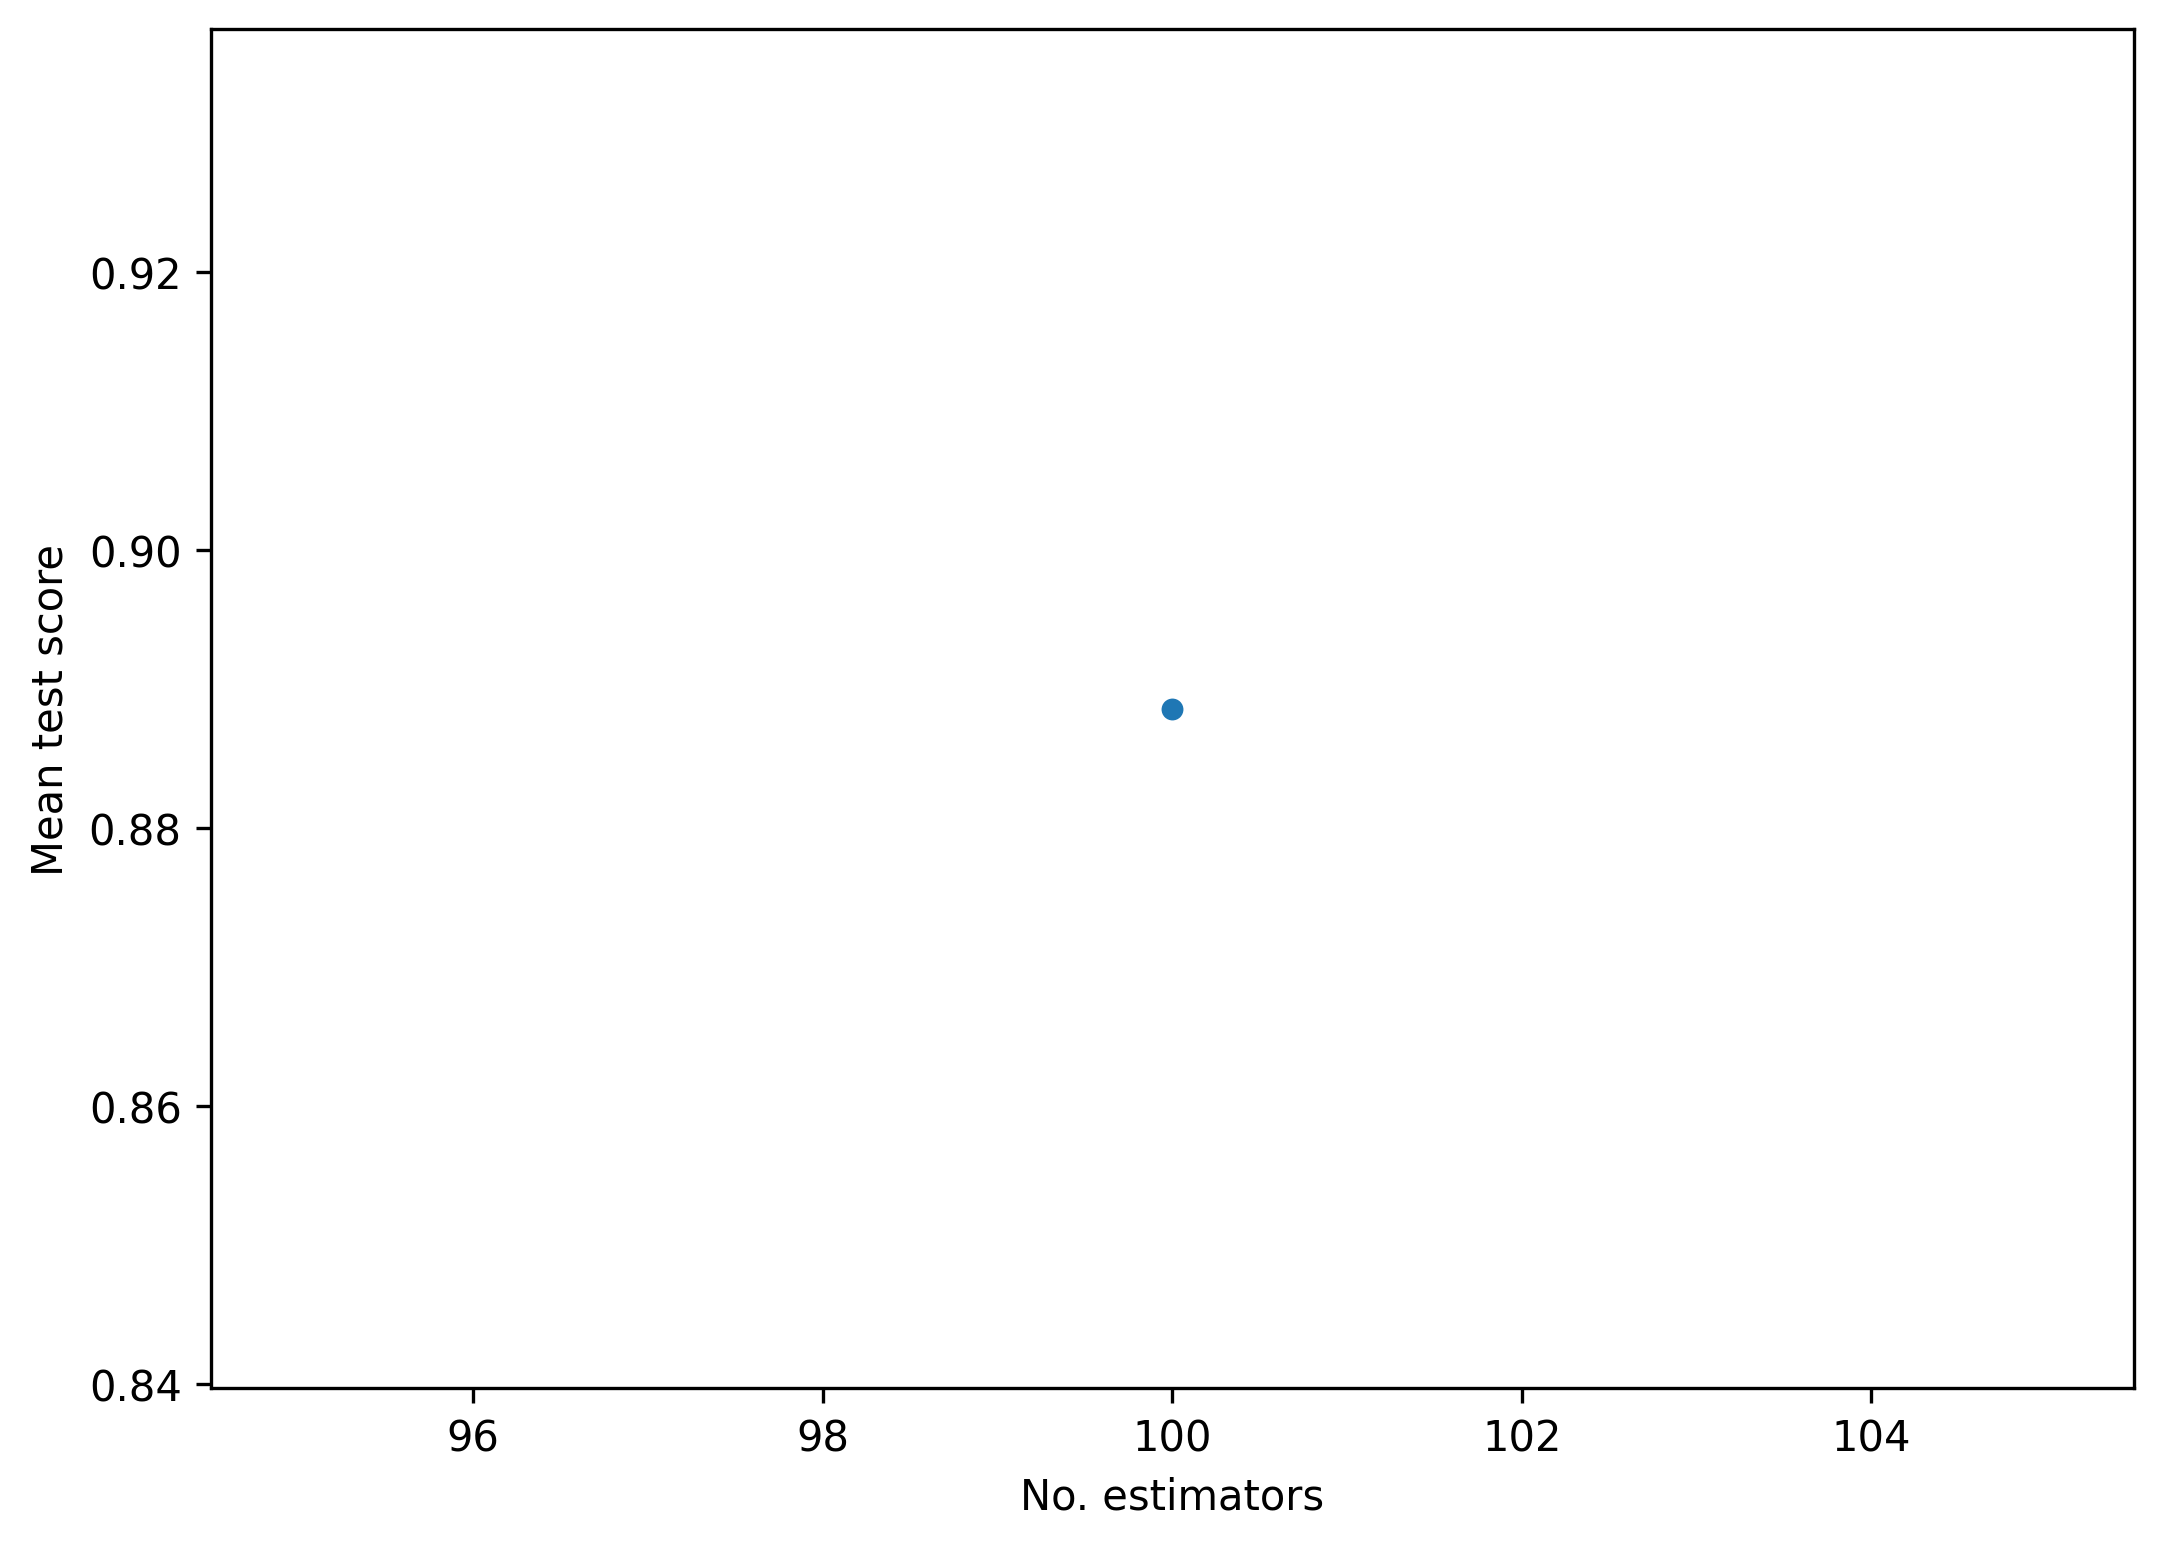

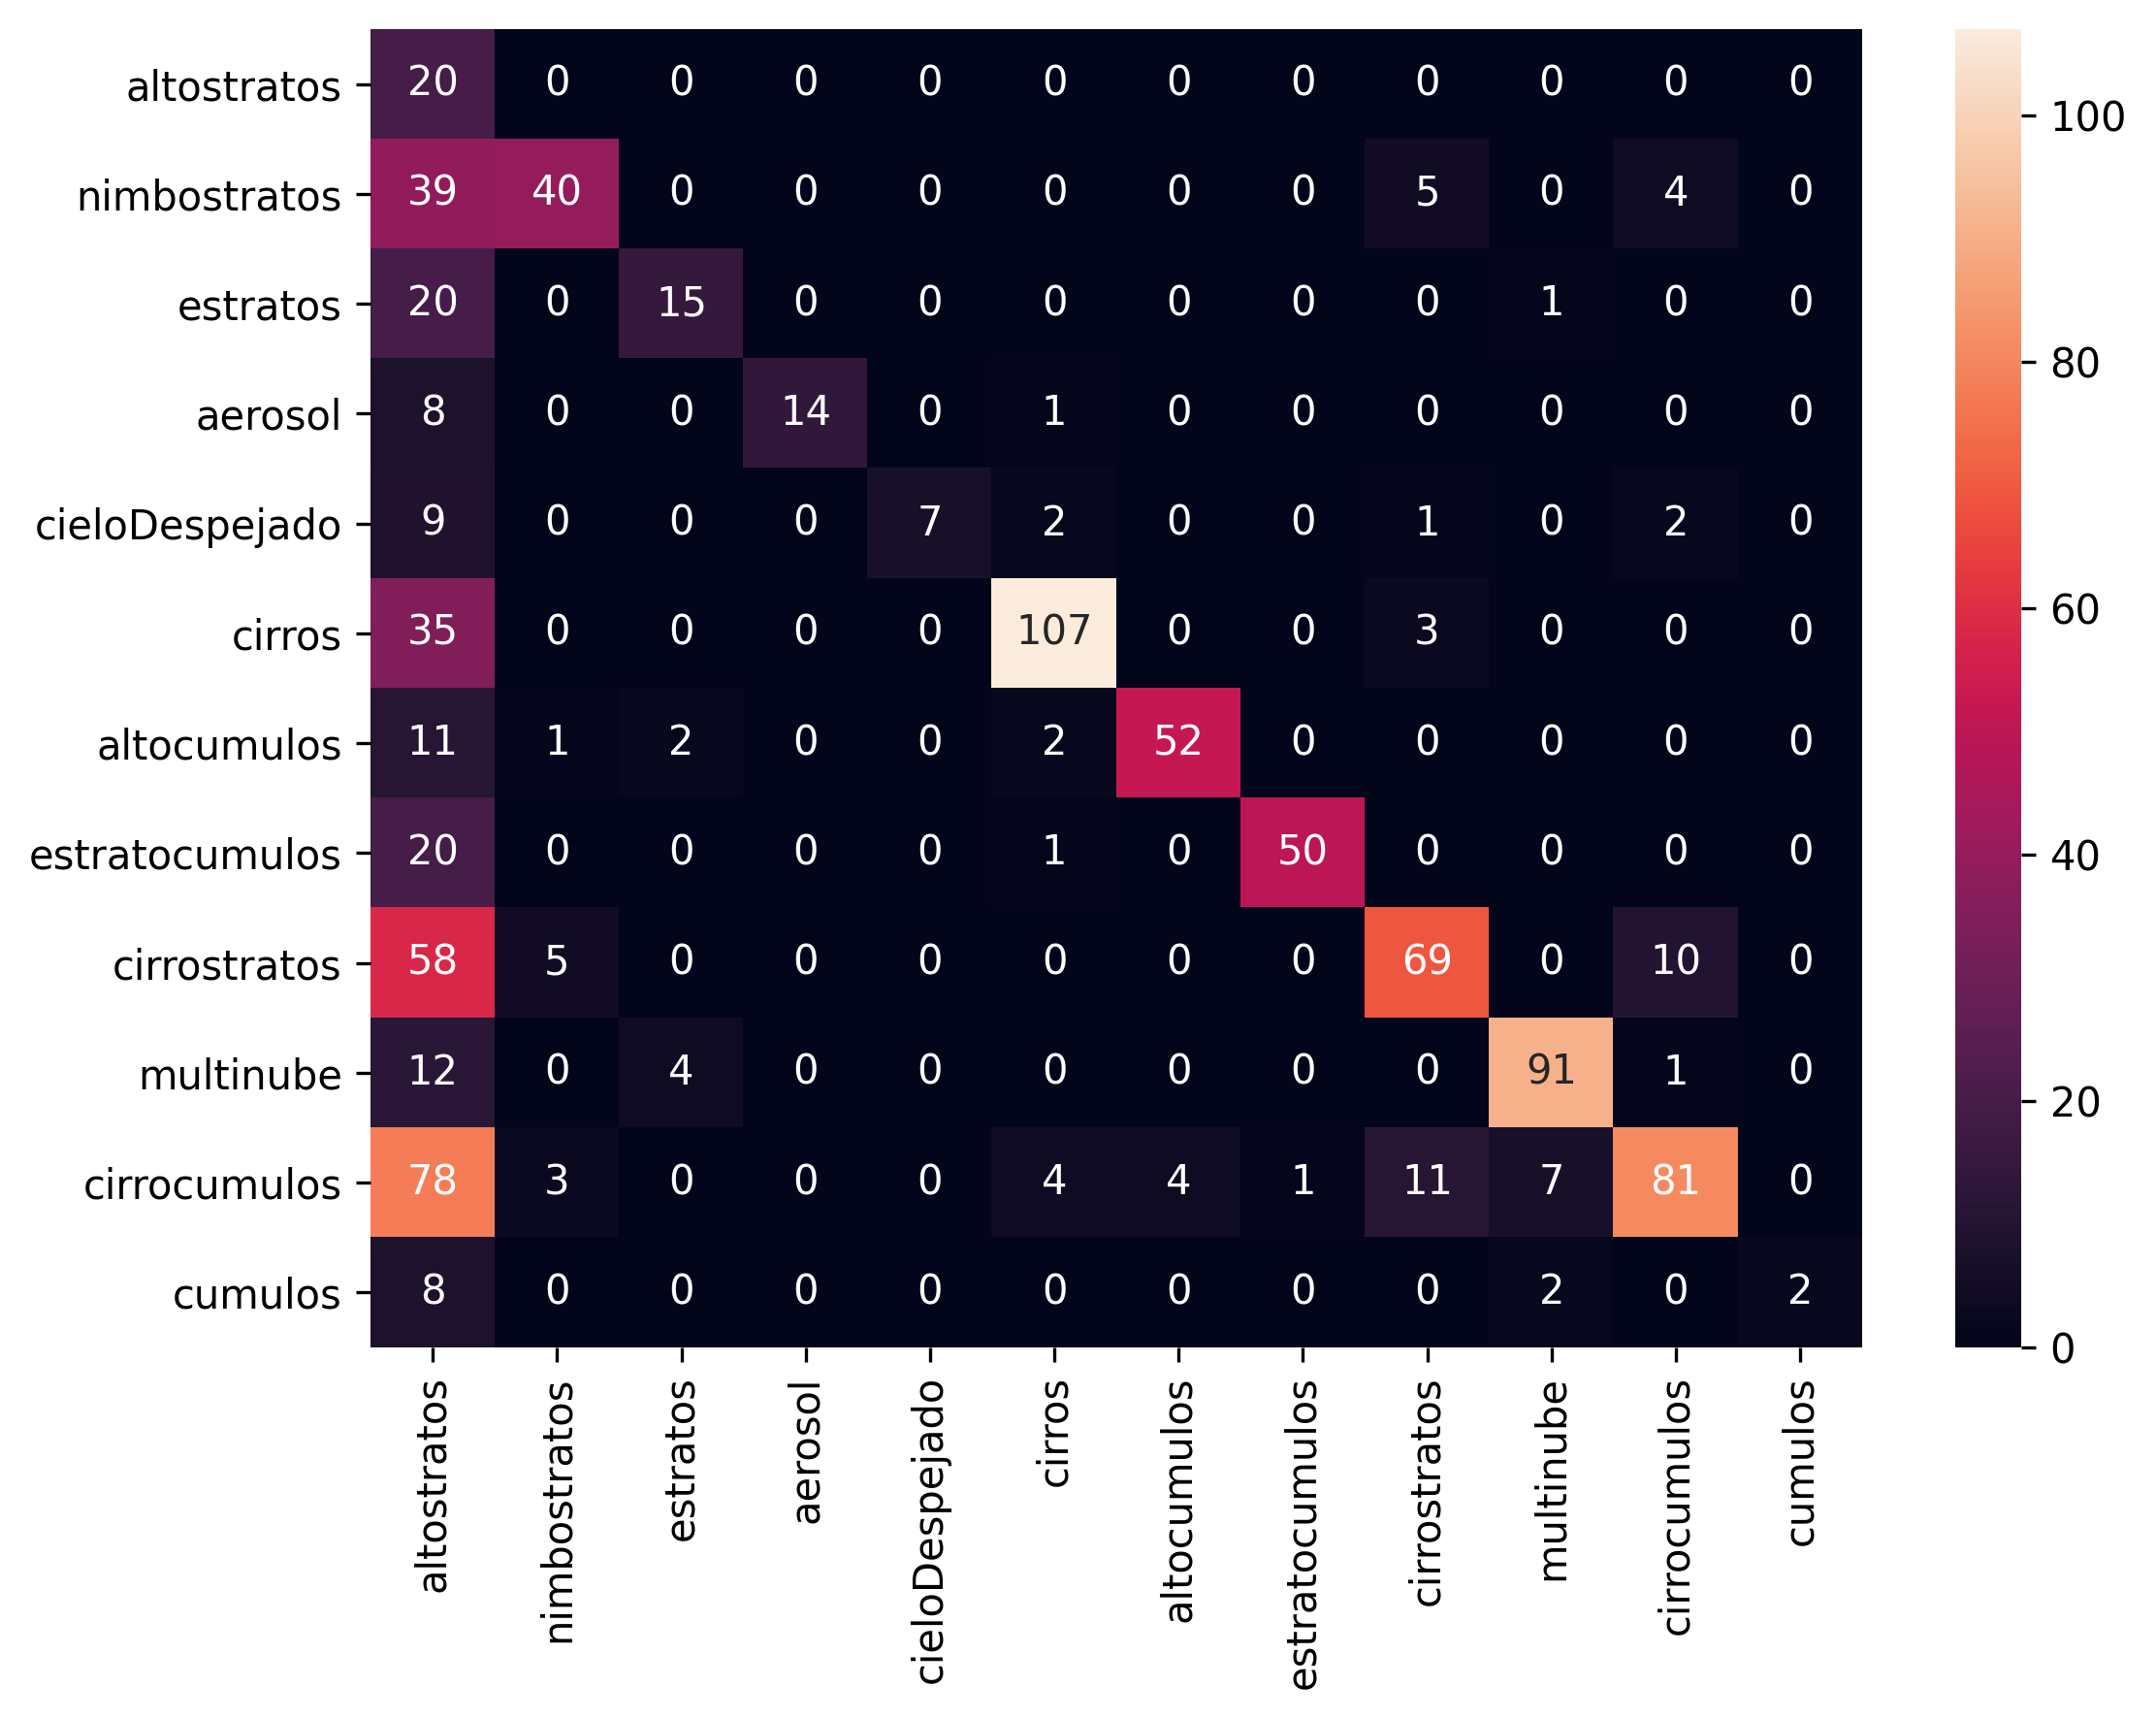

In [4]:
display(Markdown("#### Experiment 1: RF on estimators classification"))

preds_cnn_train_hot = encoder.transform(preds_cnn_train)
preds_cnn_valid_hot = encoder.transform(preds_cnn_valid)
preds_cnn_test_hot = encoder.transform(preds_cnn_test)

experiment_name = "EXP_1_RF_estimators"
print("EXPERIMENT %s" % experiment_name)
##############################################################
# Classic classifiers comparison
##############################################################
#encoder.inverse_transform(y_train)

train_classifiers_on_set(X_train=estimators_train, Y_train=encoder.inverse_transform(y_train), X_test=estimators_test, Y_test=encoder.inverse_transform(y_test), 
                         output_file_id=file_best_exec_id, experiment_name=experiment_name, output_dir=plots_dir, encoder=encoder)

##############################################################
# Training RF with different no. estimators
##############################################################
parameters_rf = {'n_estimators':list(range(100,200,100))}

# Train and evaluate Random Forest
rf_estimators = RandomForestClassifier()
grid_rf = GridSearchCV(rf_estimators, parameters_rf, verbose=10, n_jobs=10)
grid_rf.fit(estimators_train, y_train)

pd.DataFrame(grid_rf.cv_results_).to_csv(os.path.join(plots_dir, ("{}_rf_train_results_{}.csv".format(file_best_exec_id, experiment_name))))
pd.DataFrame(grid_rf.best_params_, index=[0]).to_csv(os.path.join(plots_dir, ("{}_rf_train_best_params_{}.csv".format(file_best_exec_id, experiment_name))))

##############################################################
# Plotting RF comparison no. estimators
##############################################################
fig = plt.figure(figsize=(8.27, 6), dpi=300)
ax = sns.lineplot(x="param_n_estimators", y="mean_test_score", marker="o", data=pd.DataFrame(grid_rf.cv_results_))
ax.set(xlabel='No. estimators', ylabel='Mean test score')
fig.savefig(os.path.join(plots_dir, ("{}_rf_train_results_no_estimators_{}.pdf".format(file_best_exec_id, experiment_name))), bbox_inches='tight', pad_inches=0.1)


preds_estimators_test_RF_hot = grid_rf.predict(estimators_test)
preds_estimators_test_RF = encoder.inverse_transform(preds_estimators_test_RF_hot)

print(classification_report(y_pred= preds_estimators_test_RF, y_true= y_test_dec, digits= 3))
generate_confusion_matrix_and_report(y_pred=preds_estimators_test_RF, y_test_dec=y_test_dec, output_file_id=file_best_exec_id, experiment_name=experiment_name, output_dir=plots_dir)


In [ ]:
display(Markdown("#### Experiment 2: RF over estimators + CNN predictions"))

##############################################################
# Experiment features combined 2: RF over estimators + CNN predictions
##############################################################
experiment_name = "EXP_2_RF_estimators_CNN"
print("EXPERIMENT %s" % experiment_name)

# Test set of classifiers
#preds_estimators_test_RF_hot = grid_rf.predict(estimators_test)
preds_estimators_test_RF_CNN = encoder.inverse_transform((preds_estimators_test_RF_hot + preds_cnn_test_hot)/2)

print(classification_report(y_pred= preds_estimators_test_RF_CNN, y_true= y_test_dec, digits= 3))
generate_confusion_matrix_and_report(y_pred=preds_estimators_test_RF_CNN, y_test_dec=y_test_dec, output_file_id=file_best_exec_id, experiment_name=experiment_name, output_dir=plots_dir)


In [ ]:
display(Markdown("#### Experiment 3: RF over CEIL"))
experiment_name = "EXP_3_RF_ceil"
print("EXPERIMENT %s" % experiment_name)

##############################################################
# Classic classifiers comparison
##############################################################
train_classifiers_on_set(X_train=ceil_train, Y_train=y_train, X_test=ceil_test, Y_test=y_test, output_file_id=file_best_exec_id, 
                         experiment_name=experiment_name, output_dir=plots_dir, encoder=encoder)

##############################################################
# Training RF with different no. estimators
##############################################################

# Train and evaluate Random Forest
grid_rf = GridSearchCV(RandomForestClassifier(), parameters_rf, verbose=10, n_jobs=10)
grid_rf.fit(ceil_train, y_train)

pd.DataFrame(grid_rf.cv_results_).to_csv(os.path.join(plots_dir, ("{}_rf_train_results_{}.csv".format(file_best_exec_id, experiment_name))))
pd.DataFrame(grid_rf.best_params_, index=[0]).to_csv(os.path.join(plots_dir, ("{}_rf_train_best_params_{}.csv".format(file_best_exec_id, experiment_name))))


preds_ceil_test_RF_hot = grid_rf.predict(ceil_test)
preds_ceil_test_RF = encoder.inverse_transform(preds_ceil_test_RF_hot)

print(classification_report(y_pred= preds_ceil_test_RF, y_true= y_test_dec, digits= 3))
generate_confusion_matrix_and_report(y_pred=preds_ceil_test_RF, y_test_dec=y_test_dec, output_file_id=file_best_exec_id,
                                     experiment_name=experiment_name, output_dir=plots_dir)


In [ ]:
display(Markdown("#### Experiment 4: RF over CEIL + CNN"))
experiment_name = "EXP_4_RF_ceil_CNN"
print("EXPERIMENT %s" % experiment_name)

##############################################################
# Experiment features combined 4: RF over ceil + CNN predictions
##############################################################

#preds_estimators_test_RF_hot = grid_rf.predict(estimators_test)
preds_ceil_test_RF_CNN = encoder.inverse_transform((preds_ceil_test_RF_hot + preds_cnn_test_hot)/2)

print(classification_report(y_pred= preds_ceil_test_RF_CNN, y_true= y_test_dec, digits= 3))
generate_confusion_matrix_and_report(y_pred=preds_ceil_test_RF_CNN, y_test_dec=y_test_dec, output_file_id=file_best_exec_id,
                                     experiment_name=experiment_name, output_dir=plots_dir)



In [ ]:
display(Markdown("#### Experiment 5: RF over CEIL + CNN + RF over estimators"))
experiment_name = "EXP_5_RF_ceil_CNN_RF_estimators"
print("EXPERIMENT %s" % experiment_name)

##############################################################
# Experiment features combined 4: RF over ceil + CNN predictions
##############################################################

# Test set of classifiers
#preds_estimators_test_RF_hot = grid_rf.predict(estimators_test)
preds_ceil_test_RF_CNN = encoder.inverse_transform((preds_ceil_test_RF_hot + preds_estimators_test_RF_hot + preds_cnn_test_hot)/2)

print(classification_report(y_pred= preds_ceil_test_RF_CNN, y_true= y_test_dec, digits= 3))
generate_confusion_matrix_and_report(y_pred=preds_ceil_test_RF_CNN, y_test_dec=y_test_dec, output_file_id=file_best_exec_id,
                                     experiment_name=experiment_name, output_dir=plots_dir)


In [ ]:
#https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
"""
rf = RandomForestClassifier(n_estimators=10)
#clf.fit(estimators_train, y_train)

#preds_estimators_test_RF_hot = clf.predict(estimators_test)
#preds_estimators_test_RF = encoder.inverse_transform(preds_estimators_test_RF_hot)

parameters = {'n_estimators':list(range(100,1100,100))}
clf = GridSearchCV(rf, parameters, verbose=10, n_jobs=1)
clf.fit(estimators_train, y_train)

pd.DataFrame(clf.cv_results_)

#scores = [x[1] for x in clf.grid_scores_]

#print(scores)


def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

"""
# Calling Method 
#plot_grid_search(clf.cv_results_, 2, 'N Estimators', 'Max Features')
